In [ ]:
!pip install catboost

In [28]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from collections import Counter
import xgboost as xgb
from xgboost import plot_importance
from catboost import CatBoostRegressor
from textblob import TextBlob

import tensorflow as tf

import gensim.downloader
from gensim.models import Word2Vec
import nltk

In [29]:
data_path = "data/html/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:

        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )

        code2convos[file_code] = convo_texts

100%|██████████| 127/127 [00:14<00:00,  8.53it/s]


In [ ]:
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"])

#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [31]:
prompts = []
characters_to_remove = ["\n","`",'\\']
code2prompts = defaultdict(list)
code2prompts_str = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
          for element in characters_to_remove: #Removal of such characters
            conv["text"] = conv["text"].replace(element,"")
          prompts.append(conv["text"])
          user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts

In [32]:
questions = [ #Removed a question here wasn't leading to points also removed some characters!
#####################
    """Load training dataset
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset and Preprocessing
Understanding the Dataset:
Find the shape of the dataset (number of samples and number of attributes). (Hint: You can use the **shape** function)
Display variable names (both dependent and independent).
Display the summary of the dataset. (Hint: You can use the **info** function)
Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing:
Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**
Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X and y, split data

Shuffle the dataset.
Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations

Correlations of features with health
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

Feature Selection
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

Hypothetical Driver Features
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

""",
#####################
"""Tune Hyperparameters
Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values.
Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)*
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen
Re-train model with the hyperparameters you have chosen in part 5).
Plot the tree you have trained.
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set
Predict the labels of testing data using the tree you have trained in step 6.
Report the classification accuracy.
Plot & investigate the confusion matrix. Fill the following blanks.
The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split"""
#####################
]
for item in questions:
  for element in characters_to_remove: #Removal of such characters
    item = item.replace(element,"")


In [33]:
#Train A Word2Vec Model
nltk.download('punkt')

# Tokenize sentences and create a flat list of sentences
sentence_load = []
test_list = list(code2prompts.values())
test_list.append(questions)
for sentences in test_list:
    for sentence in sentences:
        # Tokenize each sentence
        tokenized_sentence = nltk.word_tokenize(sentence)
        sentence_load.append(tokenized_sentence)

# Training the Word2Vec model
vector_size = 600
window = 5
min_count = 2

hw_grading_word2vec_model = Word2Vec(
    sentences=sentence_load,
    vector_size=vector_size,
    window=window,
    min_count= min_count,
    workers=10
)
hw_grading_word2vec_model
#Train A Word2Vec Model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [34]:
def vectorize_sentence(prompt): ## Each sentence of prompt being vectorized
  user_vector_list = list([])
  for sentence in prompt:
    tokens = sentence.split()
    word_vectors = [hw_grading_word2vec_model.wv[word] for word in tokens if word in hw_grading_word2vec_model.wv]
    if not word_vectors:
      user_vector_list.append(np.zeros(hw_grading_word2vec_model.vector_size))
      continue
    user_vector_list.append(np.mean(word_vectors, axis=0))
  return user_vector_list

code2prompts_word2vec = dict()
for code, user_prompts in code2prompts.items():
  if len(user_prompts) == 0:
      print(code+".html")
      continue
  prompts_word2Vec = pd.DataFrame(vectorize_sentence(user_prompts))
  code2prompts_word2vec[code] = prompts_word2Vec

questions_word2Vec = pd.DataFrame(vectorize_sentence(questions)) #Questions vectorized


139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [10]:
code2prompts_word2vec["7ac3f7a5-bdbb-470c-a1b3-03da5887a408"]

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,0.286379,-0.098308,-0.098390,-0.092394,0.223062,0.033763,-0.008212,0.191626,0.037303,0.050650,...,-0.159882,-0.113904,-0.027267,-0.128395,0.122646,0.056221,0.097642,-0.184512,0.037953,-0.077057
1,0.608922,-0.147139,-0.138637,-0.071863,0.483838,-0.137912,-0.126168,0.401976,0.116986,-0.022247,...,-0.095622,-0.241005,-0.115138,-0.236365,0.364534,0.315563,0.138926,-0.317609,0.122558,0.021689
2,0.208192,0.088426,0.179152,-0.208091,0.248755,-0.020072,0.050014,0.441436,-0.200625,0.401271,...,-0.314201,-0.032830,-0.020641,0.011275,0.099886,0.261320,-0.111637,-0.325210,-0.020196,0.138443
3,0.093621,0.025749,0.272762,0.140101,0.073973,-0.030338,0.297584,0.536675,-0.113292,0.161670,...,-0.122956,-0.119631,0.096613,-0.190553,0.197796,0.287418,-0.183525,-0.380377,-0.055377,-0.236210
4,0.539556,-0.123636,-0.220452,-0.007317,0.430097,-0.030592,-0.119472,0.389694,0.096932,-0.004716,...,-0.091356,-0.180398,-0.113664,-0.129999,0.363649,0.360336,0.097803,-0.353792,0.040482,-0.052802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.469223,-0.058601,-0.296448,-0.155241,0.414335,0.080206,-0.054583,0.353189,0.027907,-0.176372,...,0.013862,-0.021709,-0.097421,-0.168868,0.007751,0.288885,0.300816,-0.154695,0.005660,0.006219
60,0.601690,-0.056290,-0.105095,0.172798,0.089941,-0.118930,0.327276,0.599559,-0.162447,-0.131492,...,-0.053926,0.079905,0.029036,-0.075163,0.367463,0.263281,-0.149614,0.084281,0.108235,-0.034199
61,0.492568,-0.132616,-0.014617,-0.121389,0.348432,-0.142934,0.337839,0.653728,-0.140136,-0.086893,...,-0.199997,-0.140323,-0.139529,-0.292133,0.346171,0.339446,-0.059539,-0.189949,0.038487,0.019898
62,0.445090,-0.172964,-0.030698,-0.183899,0.313541,-0.010503,-0.202776,0.352101,0.037186,-0.028450,...,-0.147278,-0.068017,0.083475,-0.080379,0.261995,0.197009,0.027839,-0.152913,0.001910,0.015366


In [11]:
questions_word2Vec

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,0.348713,-0.136939,-0.087044,-0.064375,0.301046,0.082310,-0.147596,0.301359,-0.003833,0.058625,...,-0.093621,-0.082324,-0.020244,-0.102221,0.132254,0.218837,0.170864,-0.273554,-0.068256,-0.060099
1,0.378084,-0.065233,-0.124528,-0.031241,0.353360,0.062194,0.018636,0.359977,0.042039,0.062655,...,-0.175690,-0.126329,-0.081373,-0.134637,0.167165,0.353180,0.062420,-0.292805,0.078443,-0.135279
2,0.187890,-0.028236,0.161621,-0.032103,0.207731,-0.029073,-0.055801,0.449326,-0.159947,0.206524,...,-0.120535,0.022705,0.071594,0.027440,0.012320,0.076439,0.039687,-0.153818,-0.015409,0.056768
3,0.126076,-0.058851,0.075805,-0.137497,0.122162,0.049663,0.054157,0.304521,-0.194777,0.116595,...,-0.263713,-0.062656,-0.095827,-0.125832,0.057981,-0.014297,-0.104060,-0.227771,0.244364,-0.058392
4,0.361538,-0.072723,-0.156237,0.101496,0.201260,0.052009,0.169742,0.446841,-0.071002,-0.109174,...,-0.073561,-0.137758,-0.023154,-0.162731,0.237327,0.358757,-0.003454,-0.235824,0.155172,-0.165274
5,0.327695,-0.076489,-0.328697,-0.051763,0.279163,0.164355,0.109616,0.437695,-0.003238,-0.127205,...,-0.076047,-0.044794,-0.124396,-0.145789,0.166198,0.341660,0.147441,-0.277548,0.004694,-0.224823
6,0.383165,-0.081054,-0.150875,-0.010532,0.261923,0.027100,0.062873,0.464671,-0.039777,-0.047016,...,-0.052979,-0.017689,-0.004781,-0.128791,0.206660,0.277736,0.096289,-0.173213,-0.018513,-0.096426
7,0.470050,-0.282638,-0.041980,-0.271185,0.329579,-0.007127,-0.301542,0.528463,-0.001946,-0.058013,...,-0.237868,-0.109047,0.092720,-0.109933,0.385347,0.120708,0.005524,-0.195413,-0.009371,-0.077970


In [35]:
code2cosine_word2vec = dict()
for code, user_prompts_word2vec in code2prompts_word2vec.items():
    code2cosine_word2vec[code] = pd.DataFrame(cosine_similarity(questions_word2Vec,user_prompts_word2vec))

In [36]:
code2questionmapping_word2vec = dict()
for code, cosine_scores in code2cosine_word2vec.items():
    code2questionmapping_word2vec[code] = code2cosine_word2vec[code].max(axis=1).tolist()


question_mapping_scores_word2vec = pd.DataFrame(code2questionmapping_word2vec).T
question_mapping_scores_word2vec.reset_index(inplace=True)
question_mapping_scores_word2vec.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores_word2vec.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores_word2vec #Similarity matrix between questions and prompts of user

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.954732,0.943524,0.884733,0.958600,0.934246,0.908584,0.930156,0.844163
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.953966,0.952549,0.987223,0.952155,0.999649,0.970151,0.926270,0.982822
2,041f950b-c013-409a-a642-cffff60b9d4b,0.943902,0.965280,0.775365,0.946234,0.898222,0.918713,0.962303,0.786479
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.860941,0.887504,0.856379,0.896489,0.926696,0.870703,0.914548,0.962716
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.944843,0.946183,0.959709,0.951379,0.985559,0.969211,0.990908,0.975832
...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.943616,0.942941,0.838062,0.902389,0.926146,0.999225,0.998606,0.988353
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.927435,0.944934,0.996707,0.992037,0.990010,0.937559,0.993328,0.969111
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.982787,0.999349,0.996846,0.999544,0.999466,0.998436,0.999260,0.978491
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.977730,0.993707,0.948958,0.999680,0.985933,1.000000,1.000000,0.938995


# Feature Engineering
- Number of prompts that a uers asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

In [42]:
code2features = defaultdict(lambda : defaultdict(int))

keywords2search = ["error", "no", "thank", "next", "Entropy","how"]
keywords2search = [k.lower() for k in keywords2search]

for code, convs in code2convos.items():
  if len(convs) == 0:
      print(code)
      continue
  for c in convs:
    text = c["text"].lower()
    if c["role"] == "user":
        # User Prompts

        # count the user prompts
        code2features[code]["#user_prompts"] += 1

        # count the keywords
        for kw in keywords2search:
            code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

        code2features[code]["prompt_avg_chars"] += len(text)

        text = re.sub(r'[^\w\s]', '', text)
        words = text.split()
        blob = TextBlob(text)
        code2features[code]["unique_avg_chars"] += len(words)
        code2features[code]["sentiment_point"] += blob.sentiment.polarity

    else:
        # ChatGPT Responses
        code2features[code]["response_avg_chars"] += len(text)
        code2features[code]["response_unique_avg_chars"] += len(words)

    code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]
    code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]
    code2features[code]["unique_avg_chars"] /= code2features[code]["#user_prompts"]
    code2features[code]["sentiment_point"] /= code2features[code]["#user_prompts"]
    code2features[code]["response_unique_avg_chars"] /= code2features[code]["#user_prompts"]

139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


In [169]:
df_word2vec = pd.DataFrame(code2features).T
df_word2vec.head(5)

,#user_prompts,#error,#no,#thank,#next,#entropy,#how,prompt_avg_chars,unique_avg_chars,sentiment_point,response_avg_chars,response_unique_avg_chars
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,12.0,2.200646,0.322617,5.105060e-03,212.206370,4.515444
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,4.0,0.304163,0.055770,3.643319e-07,113.633582,1.003644
041f950b-c013-409a-a642-cffff60b9d4b,9.0,2.0,0.0,1.0,0.0,3.0,2.0,0.249785,0.052109,2.469137e-03,17.187601,0.466228
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,9.0,0.123346,0.017618,8.656510e-07,107.092566,0.352239
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,20.0,0.017986,0.003110,2.254281e-05,18.850913,0.267488


In [44]:
# reading the scores
scores = pd.read_csv("data/scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


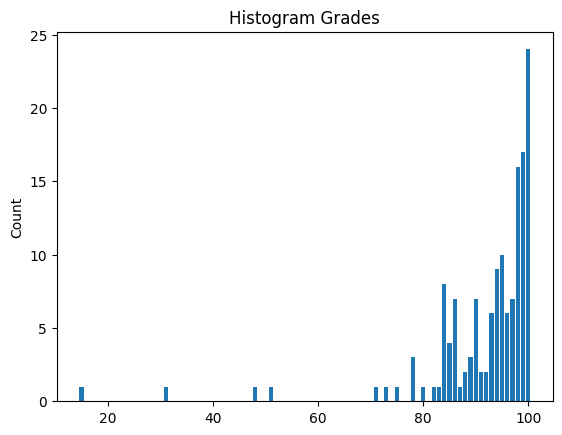

In [45]:
#Grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

In [46]:
df_word2vec.reset_index(inplace=True, drop=False)
df_word2vec.rename(columns={"index": "code"}, inplace=True)

df_word2vec.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#how,prompt_avg_chars,unique_avg_chars,sentiment_point,response_avg_chars,response_unique_avg_chars
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,12.0,2.200646,0.322617,5.105060e-03,212.206370,4.515444
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,4.0,0.304163,0.055770,3.643319e-07,113.633582,1.003644
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,2.0,0.0,1.0,0.0,3.0,2.0,0.249785,0.052109,2.469137e-03,17.187601,0.466228
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,9.0,0.123346,0.017618,8.656510e-07,107.092566,0.352239
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,20.0,0.017986,0.003110,2.254281e-05,18.850913,0.267488


In [47]:
df_word2vec = pd.merge(df_word2vec, question_mapping_scores_word2vec, on="code", how="left")
df_word2vec.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#how,prompt_avg_chars,unique_avg_chars,...,response_avg_chars,response_unique_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,12.0,2.200646,0.322617,...,212.206370,4.515444,0.954732,0.943524,0.884733,0.958600,0.934246,0.908584,0.930156,0.844163
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,4.0,0.304163,0.055770,...,113.633582,1.003644,0.953966,0.952549,0.987223,0.952155,0.999649,0.970151,0.926270,0.982822
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,2.0,0.0,1.0,0.0,3.0,2.0,0.249785,0.052109,...,17.187601,0.466228,0.943902,0.965280,0.775365,0.946234,0.898222,0.918713,0.962303,0.786479
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,9.0,0.123346,0.017618,...,107.092566,0.352239,0.860941,0.887504,0.856379,0.896489,0.926696,0.870703,0.914548,0.962716
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,20.0,0.017986,0.003110,...,18.850913,0.267488,0.944843,0.946183,0.959709,0.951379,0.985559,0.969211,0.990908,0.975832


#### Merging scores with features

In [48]:
temp_df_word2vec = pd.merge(df_word2vec, scores, on='code', how="left")
temp_df_word2vec.dropna(inplace=True)
temp_df_word2vec.drop_duplicates("code",inplace=True, keep="first")

temp_df_word2vec.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#how,prompt_avg_chars,unique_avg_chars,...,response_unique_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,12.0,2.200646,0.322617,...,4.515444,0.954732,0.943524,0.884733,0.958600,0.934246,0.908584,0.930156,0.844163,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,4.0,0.304163,0.055770,...,1.003644,0.953966,0.952549,0.987223,0.952155,0.999649,0.970151,0.926270,0.982822,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,2.0,0.0,1.0,0.0,3.0,2.0,0.249785,0.052109,...,0.466228,0.943902,0.965280,0.775365,0.946234,0.898222,0.918713,0.962303,0.786479,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,9.0,0.123346,0.017618,...,0.352239,0.860941,0.887504,0.856379,0.896489,0.926696,0.870703,0.914548,0.962716,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,20.0,0.017986,0.003110,...,0.267488,0.944843,0.946183,0.959709,0.951379,0.985559,0.969211,0.990908,0.975832,100.0


In [49]:
X_word2vec = temp_df_word2vec[temp_df_word2vec.columns[1:-1]].to_numpy()
y_word2vec = temp_df_word2vec["grade"].to_numpy()

print(X_word2vec.shape, y_word2vec.shape)

(122, 20) (122,)
(122, 20) (122,)


#### Train/Test split

In [50]:
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(X_word2vec, y_word2vec, test_size=0.2, random_state=42)
print("Train set size:", len(X_train_word2vec))
print("Test set size:", len(X_test_word2vec))

Train set size: 97
Test set size: 25
Train set size: 97
Test set size: 25


#Fitting a model

## Predicting and Analyzing

###Word2vec Decision Tree Regressor Model Implementation

In [93]:
#Initial word2vec Decision Tree Regressor Model
model_word2vec_init = DecisionTreeRegressor(criterion='squared_error', random_state=42)
model_word2vec_init.fit(X_train_word2vec, y_train_word2vec)
# word2vec Decision Tree Regressor Model evaluation
y_pred_word2vec_init = model_word2vec_init.predict(X_test_word2vec)

mae_word2vec_init = mean_absolute_error(y_test_word2vec, y_pred_word2vec_init)
mse_word2vec_init = mean_squared_error(y_test_word2vec, y_pred_word2vec_init)
rmse_word2vec_init = np.sqrt(mse_word2vec_init)
r2_word2vec_init = r2_score(y_test_word2vec, y_pred_word2vec_init)

print(f"Mean Absolute Error (MAE): {mae_word2vec_init}")
print(f"Mean Squared Error (MSE): {mse_word2vec_init}")
print(f"Root Mean Squared Error (RMSE): {rmse_word2vec_init}")
print(f"R-squared: {r2_word2vec_init}")

Mean Absolute Error (MAE): 6.12
Mean Squared Error (MSE): 121.16
Root Mean Squared Error (RMSE): 11.00727032465361
R-squared: -0.07922640595160058


In [94]:
#Cross validation check for all min_samples_split values
min_samples_split_arr = np.arange(2, 100, 3)

train_error_arr_min_samples_split = []
val_error_arr_min_samples_split = []
for min_samples_split in min_samples_split_arr:

  # Conducting cross validation
  skf = KFold(n_splits=5)

  # Arrays to save errors for each fold split
  fold_train_error_arr = []
  fold_val_error_arr = []
  for i, (train_idx, val_idx) in enumerate(skf.split(X_train_word2vec, y_train_word2vec)):
    xt = X_train_word2vec[train_idx]
    yt = y_train_word2vec[train_idx]

    xv = X_train_word2vec[val_idx]
    yv = y_train_word2vec[val_idx]

    model = DecisionTreeRegressor(
        criterion='squared_error',
        random_state=42,
        min_samples_split=min_samples_split)

    # Fitting the model to be cross validated
    model.fit(xt, yt)

    # Getting predictions
    y_pred_train = model.predict(xt)
    y_pred_val = model.predict(xv)

    # Computing error

    # Train
    train_error = mean_squared_error(y_pred_train, yt)
    fold_train_error_arr.append(train_error)

    # Validation
    valid_error = mean_squared_error(y_pred_val, yv)
    fold_val_error_arr.append(valid_error)

  # After running all splits, we compute the avgof errors in
  # the cross-validation run
  train_score_mean = np.mean(fold_train_error_arr)
  val_score_mean = np.mean(fold_val_error_arr)


  train_error_arr_min_samples_split.append(train_score_mean)
  val_error_arr_min_samples_split.append(val_score_mean)

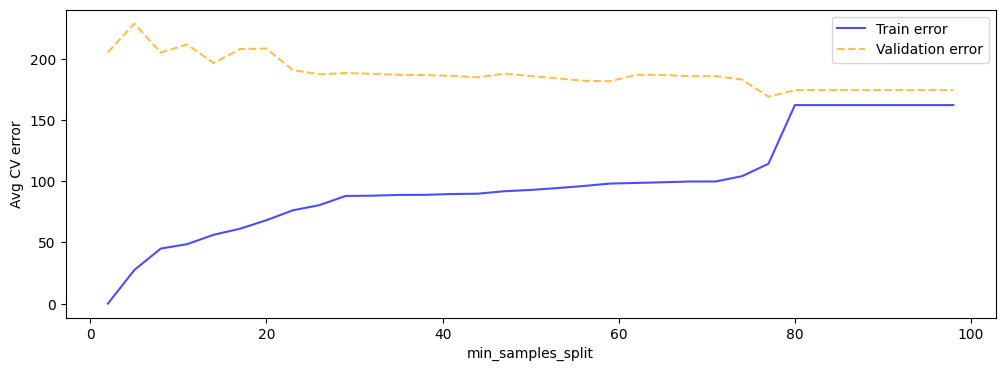

In [95]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(min_samples_split_arr, train_error_arr_min_samples_split, color='blue', alpha=0.7, label='Train error')
ax.plot(min_samples_split_arr, val_error_arr_min_samples_split, color='orange', alpha=0.7, linestyle='--', label='Validation error')
plt.legend()
ax.set_xlabel('min_samples_split')
ax.set_ylabel('Avg CV error')

plt.show()

In [96]:
#Cross Validation for max_depth of the tree
max_depth_arr = np.arange(1, 26)
train_score_error_max_depth = []
val_score_error_max_depth = []
for max_depth in max_depth_arr:
  # Conducting cross validation
  skf = KFold(n_splits=5)

  # Arrays to save errors for each fold split
  fold_train_error_arr = []
  fold_val_error_arr = []
  for i, (train_idx, val_idx) in enumerate(skf.split(X_train_word2vec, y_train_word2vec)):
    xt = X_train_word2vec[train_idx]
    yt = y_train_word2vec[train_idx]

    xv = X_train_word2vec[val_idx]
    yv = y_train_word2vec[val_idx]

    model = DecisionTreeRegressor(
        criterion='squared_error',
        random_state=42,
        max_depth=max_depth)

    # Fitting the model
    model.fit(xt, yt)

    # Getting predictions
    y_pred_train = model.predict(xt)
    y_pred_val = model.predict(xv)

    # Computing error

    # Train
    train_error = mean_squared_error(y_pred_train, yt)
    fold_train_error_arr.append(train_error)

    # Validation
    valid_error = mean_squared_error(y_pred_val, yv)
    fold_val_error_arr.append(valid_error)

  # After running all splits, we compute the avgof errors in
  # the cross-validation run
  train_score_mean = np.mean(fold_train_error_arr)
  val_score_mean = np.mean(fold_val_error_arr)

  train_score_error_max_depth.append(train_score_mean)
  val_score_error_max_depth.append(val_score_mean)

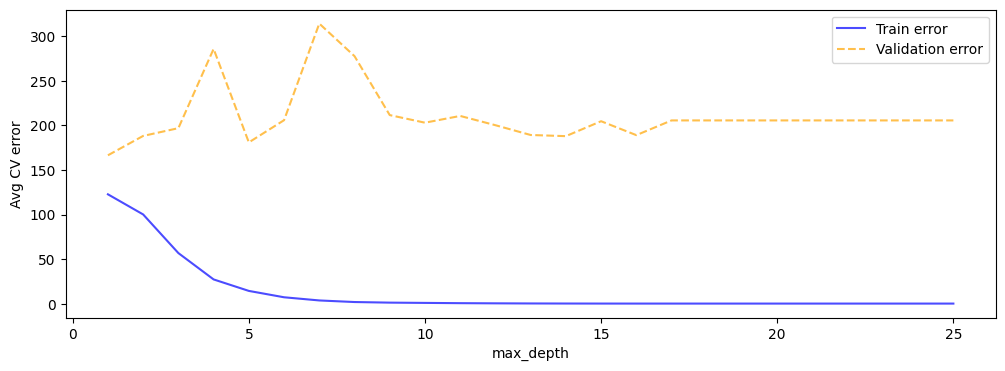

In [97]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(max_depth_arr, train_score_error_max_depth, color='blue', alpha=0.7, label='Train error')
ax.plot(max_depth_arr, val_score_error_max_depth, color='orange', alpha=0.7, linestyle='--', label='Validation error')
plt.legend()
ax.set_xlabel('max_depth')
ax.set_ylabel('Avg CV error')

plt.show()

In [113]:
#Hyper parameter search space
param_grid = {
    'max_depth': [i for i in range(6,15)],
    'min_samples_split': [j for j in range(60,75)]
}

estimator = DecisionTreeRegressor(criterion='squared_error', random_state=42)
scoring='neg_mean_squared_error'
cv = 5

grid_search_decision_tree_tune = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring=scoring,
    cv=cv
)
grid_search_decision_tree_tune.fit(X_train_word2vec, y_train_word2vec)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [6, 7, 8, 9, 10, 11, 12, 13, 14],
                         'min_samples_split': [60, 61, 62, 63, 64, 65, 66, 67,
                                               68, 69, 70, 71, 72, 73, 74]},
             scoring='neg_mean_squared_error')

In [114]:
cols_to_include = ['param_max_depth', 'param_min_samples_split', 'mean_test_score', 'std_test_score']
results = pd.DataFrame(grid_search_decision_tree_tune.cv_results_)[cols_to_include]
results.sort_values(by='mean_test_score', ascending=False)

,param_max_depth,param_min_samples_split,mean_test_score,std_test_score
0,6,60,-181.973257,195.801372
90,12,60,-181.973257,195.801372
30,8,60,-181.973257,195.801372
45,9,60,-181.973257,195.801372
60,10,60,-181.973257,195.801372
...,...,...,...,...
107,13,62,-187.229286,206.065164
106,13,61,-187.229286,206.065164
48,9,63,-187.229286,206.065164
1,6,61,-187.229286,206.065164


In [115]:
#Use parameters that were the best from previous part
model_word2vec_tuned = DecisionTreeRegressor(
    criterion='squared_error',
    random_state=42,
    max_depth=6,
    min_samples_split=60
)

model_word2vec_tuned.fit(X_train_word2vec, y_train_word2vec)
y_pred_word2vec_tuned = model_word2vec_tuned.predict(X_test_word2vec)

mae_word2vec_tuned = mean_absolute_error(y_test_word2vec, y_pred_word2vec_tuned)
mse_word2vec_tuned = mean_squared_error(y_test_word2vec, y_pred_word2vec_tuned)
rmse_word2vec_tuned = np.sqrt(mse_word2vec_tuned)
r2_word2vec_tuned = r2_score(y_test_word2vec, y_pred_word2vec_tuned)

print(f"Mean Absolute Error (MAE): {mae_word2vec_tuned}")
print(f"Mean Squared Error (MSE): {mse_word2vec_tuned}")
print(f"Root Mean Squared Error (RMSE): {rmse_word2vec_tuned}")
print(f"R-squared: {r2_word2vec_tuned}")

Mean Absolute Error (MAE): 6.010098870056497
Mean Squared Error (MSE): 97.49985104156694
Root Mean Squared Error (RMSE): 9.874201286259408
R-squared: 0.13152514179261543


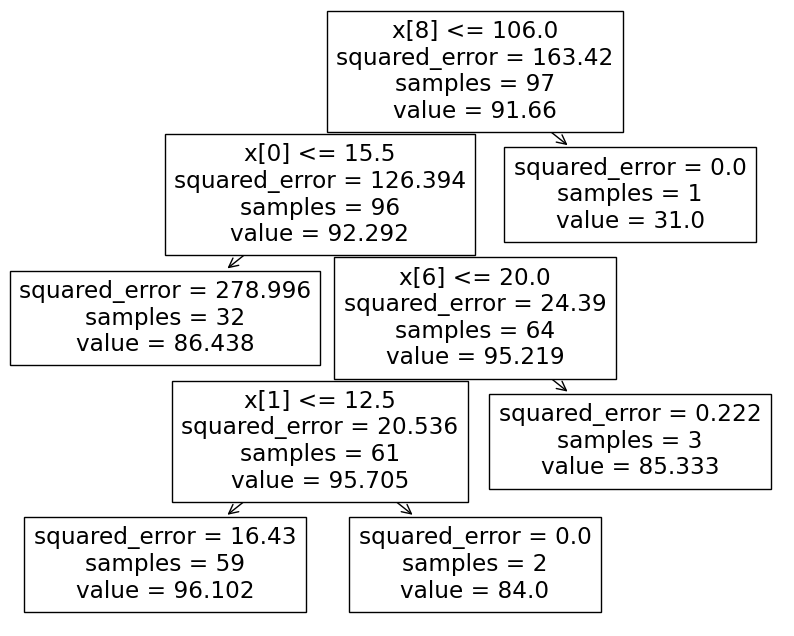

In [116]:
plt.figure(figsize=(10, 8))
plot_tree(model_word2vec_tuned)
plt.show()

###Word2vec Random Forest Regressor Model Implementation

In [117]:
#Random Forest Regressor Model
model_word2vec_init1 = RandomForestRegressor(
  criterion='squared_error',
  random_state=42)

model_word2vec_init1.fit(X_train_word2vec, y_train_word2vec)

y_pred_word2vec_init1 = model_word2vec_init1.predict(X_test_word2vec)

mae_word2vec_init1 = mean_absolute_error(y_test_word2vec, y_pred_word2vec_init1)
mse_word2vec_init1 = mean_squared_error(y_test_word2vec, y_pred_word2vec_init1)
rmse_word2vec_init1 = np.sqrt(mse_word2vec_init1)
r2_word2vec_init1 = r2_score(y_test_word2vec, y_pred_word2vec_init1)

print(f"Mean Absolute Error (MAE): {mae_word2vec_init1}")
print(f"Mean Squared Error (MSE): {mse_word2vec_init1}")
print(f"Root Mean Squared Error (RMSE): {rmse_word2vec_init1}")
print(f"R-squared: {r2_word2vec_init1}")

Mean Absolute Error (MAE): 6.353400000000001
Mean Squared Error (MSE): 104.231997
Root Mean Squared Error (RMSE): 10.209407279563296
R-squared: 0.07155890139098697


In [118]:
#Cross Validation for min_samples_split of the tree
min_samples_split_arr = np.arange(2, 100, 3)

train_error_arr_min_samples_split = []
val_error_arr_min_samples_split = []
for min_samples_split in min_samples_split_arr:

  # Conducting cross validation
  skf = KFold(n_splits=5)

  # Arrays to save errors for each fold split
  fold_train_error_arr = []
  fold_val_error_arr = []
  for i, (train_idx, val_idx) in enumerate(skf.split(X_train_word2vec, y_train_word2vec)):
    xt = X_train_word2vec[train_idx]
    yt = y_train_word2vec[train_idx]

    xv = X_train_word2vec[val_idx]
    yv = y_train_word2vec[val_idx]

    model = RandomForestRegressor(
        criterion='squared_error',
        random_state=42,
        min_samples_split=min_samples_split)

    # Fitting the model
    model.fit(xt, yt)

    # Getting predictions
    y_pred_train = model.predict(xt)
    y_pred_val = model.predict(xv)

    # Computing error

    # Train
    train_error = mean_squared_error(y_pred_train, yt)
    fold_train_error_arr.append(train_error)

    # Validation
    valid_error = mean_squared_error(y_pred_val, yv)
    fold_val_error_arr.append(valid_error)

  train_score_mean = np.mean(fold_train_error_arr)
  val_score_mean = np.mean(fold_val_error_arr)

  train_error_arr_min_samples_split.append(train_score_mean)
  val_error_arr_min_samples_split.append(val_score_mean)

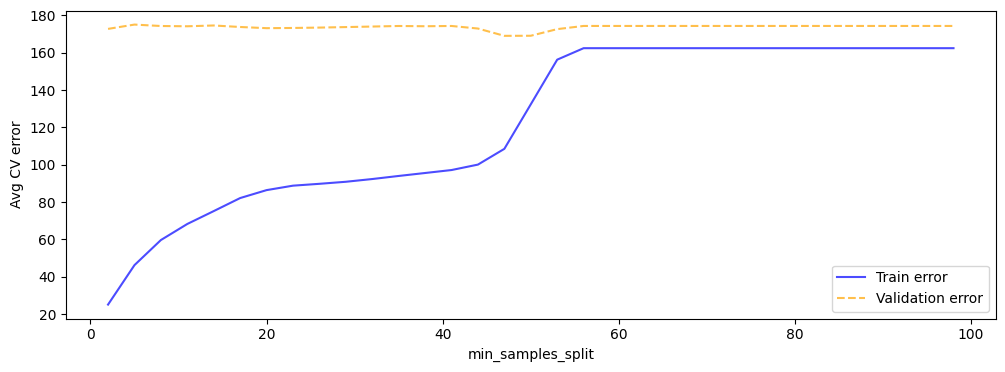

In [119]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(min_samples_split_arr, train_error_arr_min_samples_split, color='blue', alpha=0.7, label='Train error')
ax.plot(min_samples_split_arr, val_error_arr_min_samples_split, color='orange', alpha=0.7, linestyle='--', label='Validation error')
plt.legend()
ax.set_xlabel('min_samples_split')
ax.set_ylabel('Avg CV error')

plt.show()

In [120]:
#Cross Validation for max_depth of the tree
max_depth_arr = np.arange(1, 26)
train_score_error_max_depth = []
val_score_error_max_depth = []
for max_depth in max_depth_arr:
  skf = KFold(n_splits=5)

  fold_train_error_arr = []
  fold_val_error_arr = []
  for i, (train_idx, val_idx) in enumerate(skf.split(X_train_word2vec, y_train_word2vec)):
    xt = X_train_word2vec[train_idx]
    yt = y_train_word2vec[train_idx]

    xv = X_train_word2vec[val_idx]
    yv = y_train_word2vec[val_idx]

    model = RandomForestRegressor(
        criterion='squared_error',
        random_state=42,
        max_depth=max_depth)

    # Fitting the model
    model.fit(xt, yt)

    # Getting predictions
    y_pred_train = model.predict(xt)
    y_pred_val = model.predict(xv)

    # Computing accuracy

    # Train
    train_error = mean_squared_error(y_pred_train, yt)
    fold_train_error_arr.append(train_error)

    # Validation
    valid_error = mean_squared_error(y_pred_val, yv)
    fold_val_error_arr.append(valid_error)

  train_score_mean = np.mean(fold_train_error_arr)
  val_score_mean = np.mean(fold_val_error_arr)

  train_score_error_max_depth.append(train_score_mean)
  val_score_error_max_depth.append(val_score_mean)

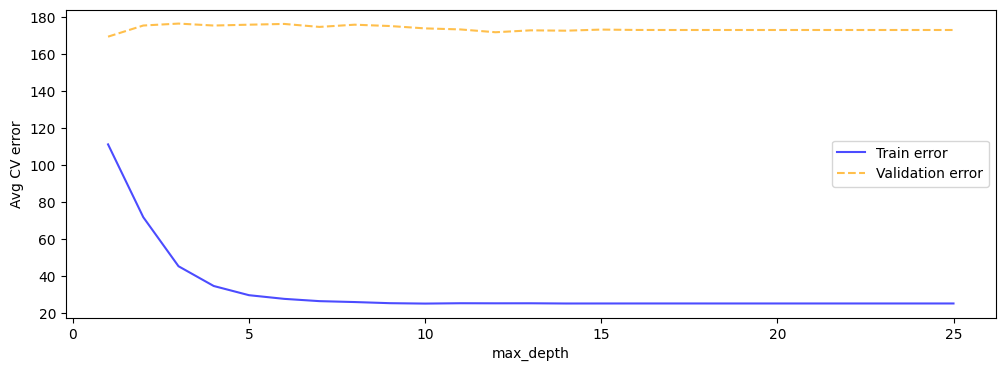

In [121]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(max_depth_arr, train_score_error_max_depth, color='blue', alpha=0.7, label='Train error')
ax.plot(max_depth_arr, val_score_error_max_depth, color='orange', alpha=0.7, linestyle='--', label='Validation error')
plt.legend()
ax.set_xlabel('max_depth')
ax.set_ylabel('Avg CV error')

plt.show()

In [128]:
param_grid = {
    'max_depth': [i for i in range(10,18)],
    'min_samples_split': [j for j in range(40,62)],
}

estimator = RandomForestRegressor(criterion='squared_error', random_state=42)
scoring='neg_mean_squared_error'
cv = 5

grid_search_randomforest_tune = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring=scoring,
    cv=cv
)
grid_search_randomforest_tune.fit(X_train_word2vec, y_train_word2vec)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [10, 11, 12, 13, 14, 15, 16, 17],
                         'min_samples_split': [40, 41, 42, 43, 44, 45, 46, 47,
                                               48, 49, 50, 51, 52, 53, 54, 55,
                                               56, 57, 58, 59, 60, 61]},
             scoring='neg_mean_squared_error')

In [131]:
cols_to_include = ['param_max_depth', 'param_min_samples_split', 'mean_test_score', 'std_test_score']
results = pd.DataFrame(grid_search_randomforest_tune.cv_results_)[cols_to_include]
results.sort_values(by='mean_test_score', ascending=False)

,param_max_depth,param_min_samples_split,mean_test_score,std_test_score
75,13,49,-166.012655,207.373081
141,16,49,-166.012655,207.373081
31,11,49,-166.012655,207.373081
53,12,49,-166.012655,207.373081
97,14,49,-166.012655,207.373081
...,...,...,...,...
43,11,61,-174.368535,220.367622
42,11,60,-174.368535,220.367622
41,11,59,-174.368535,220.367622
40,11,58,-174.368535,220.367622


In [136]:
model_word2vec_tuned1 = RandomForestRegressor(
    criterion='squared_error',
    random_state=42,
    max_depth=13,
    min_samples_split=49,
    n_estimators = 1000
)

model_word2vec_tuned1.fit(X_train_word2vec, y_train_word2vec)
y_pred_word2vec_tuned1 = model_word2vec_tuned1.predict(X_test_word2vec)

mae_word2vec_tuned1 = mean_absolute_error(y_test_word2vec, y_pred_word2vec_tuned1)
mse_word2vec_tuned1 = mean_squared_error(y_test_word2vec, y_pred_word2vec_tuned1)
rmse_word2vec_tuned1 = np.sqrt(mse_word2vec_tuned1)
r2_word2vec_tuned1 = r2_score(y_test_word2vec, y_pred_word2vec_tuned1)

print(f"Mean Absolute Error (MAE): {mae_word2vec_tuned1}")
print(f"Mean Squared Error (MSE): {mse_word2vec_tuned1}")
print(f"Root Mean Squared Error (RMSE): {rmse_word2vec_tuned1}")
print(f"R-squared: {r2_word2vec_tuned1}")

Mean Absolute Error (MAE): 6.6124259838665616
Mean Squared Error (MSE): 101.36653471465308
Root Mean Squared Error (RMSE): 10.068094890030242
R-squared: 0.09708285784200066


###Word2vec Gradient Boosting Regressor Model Implementation

In [146]:
model_word2vec_init2 = GradientBoostingRegressor(criterion = 'squared_error',learning_rate=0.1, random_state=42)
model_word2vec_init2.fit(X_train_word2vec, y_train_word2vec)
y_pred_word2vec_init2 = model_word2vec_init2.predict(X_test_word2vec)

mae_word2vec_init2 = mean_absolute_error(y_test_word2vec, y_pred_word2vec_init2)
mse_word2vec_init2 = mean_squared_error(y_test_word2vec, y_pred_word2vec_init2)
rmse_word2vec_init2 = np.sqrt(mse_word2vec_init2)
r2_word2vec_init2 = r2_score(y_test_word2vec, y_pred_word2vec_init2)

print(f"Mean Absolute Error (MAE): {mae_word2vec_init2}")
print(f"Mean Squared Error (MSE): {mse_word2vec_init2}")
print(f"Root Mean Squared Error (RMSE): {rmse_word2vec_init2}")
print(f"R-squared: {r2_word2vec_init2}")

Mean Absolute Error (MAE): 6.256146025545263
Mean Squared Error (MSE): 108.88417923457595
Root Mean Squared Error (RMSE): 10.434758225976104
R-squared: 0.030119829809167276


In [147]:
min_samples_split_arr = np.arange(2, 100, 3)

train_error_arr_min_samples_split = []
val_error_arr_min_samples_split = []
for min_samples_split in min_samples_split_arr:
  skf = KFold(n_splits=5)

  fold_train_error_arr = []
  fold_val_error_arr = []
  for i, (train_idx, val_idx) in enumerate(skf.split(X_train_word2vec, y_train_word2vec)):
    xt = X_train_word2vec[train_idx]
    yt = y_train_word2vec[train_idx]

    xv = X_train_word2vec[val_idx]
    yv = y_train_word2vec[val_idx]

    model = GradientBoostingRegressor(
        criterion='squared_error',
        random_state=42,
        min_samples_split=min_samples_split)

    # Fitting the model
    model.fit(xt, yt)

    # Getting predictions
    y_pred_train = model.predict(xt)
    y_pred_val = model.predict(xv)

    # Computing error

    # Train
    train_error = mean_squared_error(y_pred_train, yt)
    fold_train_error_arr.append(train_error)

    # Validation
    valid_error = mean_squared_error(y_pred_val, yv)
    fold_val_error_arr.append(valid_error)


  train_score_mean = np.mean(fold_train_error_arr)
  val_score_mean = np.mean(fold_val_error_arr)

  train_error_arr_min_samples_split.append(train_score_mean)
  val_error_arr_min_samples_split.append(val_score_mean)

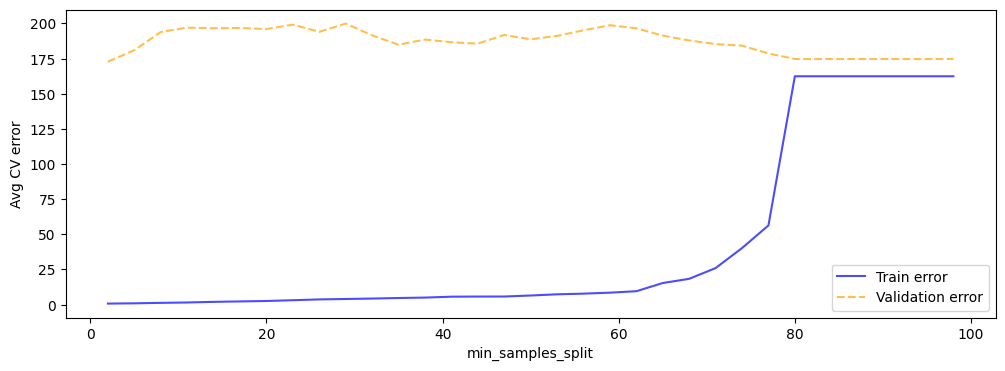

In [148]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(min_samples_split_arr, train_error_arr_min_samples_split, color='blue', alpha=0.7, label='Train error')
ax.plot(min_samples_split_arr, val_error_arr_min_samples_split, color='orange', alpha=0.7, linestyle='--', label='Validation error')
plt.legend()
ax.set_xlabel('min_samples_split')
ax.set_ylabel('Avg CV error')

plt.show()

In [149]:
max_depth_arr = np.arange(1, 26)
train_score_error_max_depth = []
val_score_error_max_depth = []
for max_depth in max_depth_arr:
  # Conducting cross validation
  skf = KFold(n_splits=5)

  # Arrays to save accuracies for each fold split
  fold_train_error_arr = []
  fold_val_error_arr = []
  for i, (train_idx, val_idx) in enumerate(skf.split(X_train_word2vec, y_train_word2vec)):
    xt = X_train_word2vec[train_idx]
    yt = y_train_word2vec[train_idx]

    xv = X_train_word2vec[val_idx]
    yv = y_train_word2vec[val_idx]

    model = GradientBoostingRegressor(
        criterion='squared_error',
        random_state=42,
        max_depth=max_depth)

    # Fitting the model
    model.fit(xt, yt)

    # Getting predictions
    y_pred_train = model.predict(xt)
    y_pred_val = model.predict(xv)

    # Computing accuracy

    # Train
    train_error = mean_squared_error(y_pred_train, yt)
    fold_train_error_arr.append(train_error)

    # Validation
    valid_error = mean_squared_error(y_pred_val, yv)
    fold_val_error_arr.append(valid_error)

  train_score_mean = np.mean(fold_train_error_arr)
  val_score_mean = np.mean(fold_val_error_arr)

  train_score_error_max_depth.append(train_score_mean)
  val_score_error_max_depth.append(val_score_mean)

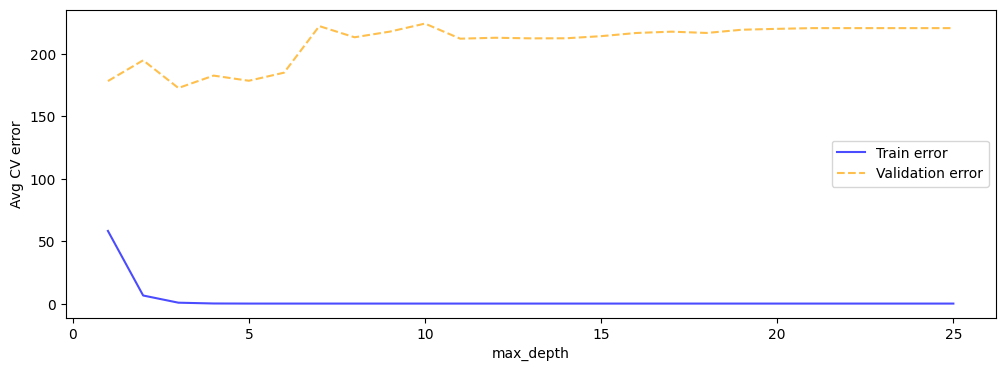

In [150]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(max_depth_arr, train_score_error_max_depth, color='blue', alpha=0.7, label='Train error')
ax.plot(max_depth_arr, val_score_error_max_depth, color='orange', alpha=0.7, linestyle='--', label='Validation error')
plt.legend()
ax.set_xlabel('max_depth')
ax.set_ylabel('Avg CV error')

plt.show()

In [139]:
param_grid = {
    'max_depth': [i for i in range(3,16)],
    'min_samples_split': [j for j in range(60,81)]
}

estimator = GradientBoostingRegressor(criterion='squared_error', random_state=42)
scoring='neg_mean_squared_error'
cv = 5

grid_search_gradient_boosting_tune = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring=scoring,
    cv=cv
)
grid_search_gradient_boosting_tune.fit(X_train_word2vec, y_train_word2vec)

GridSearchCV(cv=5,
             estimator=GradientBoostingRegressor(criterion='squared_error',
                                                 random_state=42),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                       15],
                         'min_samples_split': [60, 61, 62, 63, 64, 65, 66, 67,
                                               68, 69, 70, 71, 72, 73, 74, 75,
                                               76, 77, 78, 79, 80]},
             scoring='neg_mean_squared_error')

In [140]:
cols_to_include = ['param_max_depth', 'param_min_samples_split', 'mean_test_score', 'std_test_score']
results = pd.DataFrame(grid_search_gradient_boosting_tune.cv_results_)[cols_to_include]
results.sort_values(by='mean_test_score', ascending=False)

,param_max_depth,param_min_samples_split,mean_test_score,std_test_score
60,5,78,-172.009176,225.006649
144,9,78,-172.009176,225.006649
249,14,78,-172.009176,225.006649
207,12,78,-172.009176,225.006649
18,3,78,-172.009176,225.006649
...,...,...,...,...
172,11,64,-197.265499,204.308027
23,4,62,-197.439314,210.382407
0,3,60,-198.860676,207.566884
25,4,64,-199.357324,203.916335


In [145]:
model_word2vec_tuned2 = GradientBoostingRegressor(
    criterion='squared_error',
    random_state=42,
    max_depth=5,
    min_samples_split=78,
    n_estimators = 1000
)

model_word2vec_tuned2.fit(X_train_word2vec, y_train_word2vec)
y_pred_word2vec_tuned2 = model_word2vec_tuned2.predict(X_test_word2vec)

mae_word2vec_tuned2 = mean_absolute_error(y_test_word2vec, y_pred_word2vec_tuned2)
mse_word2vec_tuned2 = mean_squared_error(y_test_word2vec, y_pred_word2vec_tuned2)
rmse_word2vec_tuned2 = np.sqrt(mse_word2vec_tuned2)
r2_word2vec_tuned2 = r2_score(y_test_word2vec, y_pred_word2vec_tuned2)

print(f"Mean Absolute Error (MAE): {mae_word2vec_tuned2}")
print(f"Mean Squared Error (MSE): {mse_word2vec_tuned2}")
print(f"Root Mean Squared Error (RMSE): {rmse_word2vec_tuned2}")
print(f"R-squared: {r2_word2vec_tuned2}")

Mean Absolute Error (MAE): 7.280635515612705
Mean Squared Error (MSE): 119.20765305385295
Root Mean Squared Error (RMSE): 10.918225728288133
R-squared: -0.061835976949777605


###Word2vec XGBoost Regressor Model Implementation

In [151]:
model_word2vec_init3 = xgb.XGBRegressor()
model_word2vec_init3.fit(X_train_word2vec, y_train_word2vec)

y_pred_word2vec_init3 = model_word2vec_init3.predict(X_test_word2vec)

mae_word2vec_init3 = mean_absolute_error(y_test_word2vec, y_pred_word2vec_init3)
mse_word2vec_init3 = mean_squared_error(y_test_word2vec, y_pred_word2vec_init3)
rmse_word2vec_init3 = np.sqrt(mse_word2vec_init3)
r2_word2vec_init3 = r2_score(y_test_word2vec, y_pred_word2vec_init3)

print(f"Mean Absolute Error (MAE): {mae_word2vec_init3}")
print(f"Mean Squared Error (MSE): {mse_word2vec_init3}")
print(f"Root Mean Squared Error (RMSE): {rmse_word2vec_init3}")
print(f"R-squared: {r2_word2vec_init3}")

Mean Absolute Error (MAE): 6.325052490234375
Mean Squared Error (MSE): 90.70253547872417
Root Mean Squared Error (RMSE): 9.523787874513175
R-squared: 0.19207187706007744


In [152]:
param_grid = {
    'max_depth': [3,6,10],
    'n_estimators': [100,150,200,250,300,500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5, 1],
    'colsample_bytree': [0.3, 0.55, 0.7]
}

estimator = xgb.XGBRegressor()
scoring='neg_mean_squared_error'
cv = 5

grid_search_XGBoost_tune = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring=scoring,
    cv=cv,
    verbose=1
)
grid_search_XGBoost_tune.fit(X_train_word2vec, y_train_word2vec)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.55, 0.7],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5, 1],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [100, 150, 200, 250, 300, 500]},
             scoring='neg_mean_squared_error', verbose=1)

In [155]:
cols_to_include = ['param_max_depth', 'param_n_estimators','param_learning_rate','param_colsample_bytree','mean_test_score', 'std_test_score']
results = pd.DataFrame(grid_search_XGBoost_tune.cv_results_)[cols_to_include]
results.sort_values(by='mean_test_score', ascending=False)

,param_max_depth,param_n_estimators,param_learning_rate,param_colsample_bytree,mean_test_score,std_test_score
6,6,100,0.01,0.3,-169.728657,220.978993
216,3,100,0.01,0.7,-169.749093,212.836795
120,10,100,0.01,0.55,-169.775222,214.220620
108,3,100,0.01,0.55,-169.783624,213.185263
217,3,150,0.01,0.7,-169.857142,209.647252
...,...,...,...,...,...,...
101,6,500,1,0.3,-296.732975,229.781589
100,6,300,1,0.3,-296.732975,229.781589
99,6,250,1,0.3,-296.732975,229.781589
98,6,200,1,0.3,-296.732975,229.781589


In [156]:
model_word2vec_tuned3 = xgb.XGBRegressor(
    max_depth = 6,
    n_estimators = 100,
    learning_rate = 0.01,
    colsample_bytree = 0.3
)

model_word2vec_tuned3.fit(X_train_word2vec, y_train_word2vec)
y_pred_word2vec_tuned3 = model_word2vec_tuned3.predict(X_test_word2vec)

mae_word2vec_tuned3 = mean_absolute_error(y_test_word2vec, y_pred_word2vec_tuned3)
mse_word2vec_tuned3 = mean_squared_error(y_test_word2vec, y_pred_word2vec_tuned3)
rmse_word2vec_tuned3 = np.sqrt(mse_word2vec_tuned3)
r2_word2vec_tuned3 = r2_score(y_test_word2vec, y_pred_word2vec_tuned3)

print(f"Mean Absolute Error (MAE): {mae_word2vec_tuned3}")
print(f"Mean Squared Error (MSE): {mse_word2vec_tuned3}")
print(f"Root Mean Squared Error (RMSE): {rmse_word2vec_tuned3}")
print(f"R-squared: {r2_word2vec_tuned3}")

Mean Absolute Error (MAE): 6.0346136474609375
Mean Squared Error (MSE): 93.6589761661226
Root Mean Squared Error (RMSE): 9.677756773453371
R-squared: 0.16573753521895762


###Word2vec CatBoost Regression Implementation

In [159]:
model_word2vec_init4 = CatBoostRegressor(verbose=0)
model_word2vec_init4.fit(X_train_word2vec, y_train_word2vec)

y_pred_word2vec_init4 = model_word2vec_init4.predict(X_test_word2vec)

mae_word2vec_init4 = mean_absolute_error(y_test_word2vec, y_pred_word2vec_init4)
mse_word2vec_init4 = mean_squared_error(y_test_word2vec, y_pred_word2vec_init4)
rmse_word2vec_init4 = np.sqrt(mse_word2vec_init4)
r2_word2vec_init4 = r2_score(y_test_word2vec, y_pred_word2vec_init4)

print(f"Mean Absolute Error (MAE): {mae_word2vec_init4}")
print(f"Mean Squared Error (MSE): {mse_word2vec_init4}")
print(f"Root Mean Squared Error (RMSE): {rmse_word2vec_init4}")
print(f"R-squared: {r2_word2vec_init4}")

Mean Absolute Error (MAE): 6.16258638979705
Mean Squared Error (MSE): 91.96429359833576
Root Mean Squared Error (RMSE): 9.589801541133985
R-squared: 0.18083283215574708


In [163]:
param_grid = {
  'depth': [x for x in range(0,10)],
  'learning_rate': [0.01, 0.05, 1]
}

estimator = CatBoostRegressor(verbose=0)
scoring='neg_mean_squared_error'
cv = 5

grid_search_CatBoost_tune = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring=scoring,
    cv=cv,
    verbose=1
)
grid_search_CatBoost_tune.fit(X_train_word2vec, y_train_word2vec)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7c0a97b27e20>,
             param_grid={'depth': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'learning_rate': [0.01, 0.05, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [165]:
cols_to_include = ['param_depth','param_learning_rate','mean_test_score', 'std_test_score']
results = pd.DataFrame(grid_search_CatBoost_tune.cv_results_)[cols_to_include]
results.sort_values(by='mean_test_score', ascending=False)

,param_depth,param_learning_rate,mean_test_score,std_test_score
21,7,0.01,-171.979136,223.427858
24,8,0.01,-172.400134,226.454129
27,9,0.01,-172.640603,227.506521
15,5,0.01,-173.293879,226.042403
12,4,0.01,-173.827035,226.748845
18,6,0.01,-173.863708,225.223398
22,7,0.05,-174.100026,225.313656
1,0,0.05,-174.744524,221.101220
2,0,1,-174.744524,221.101220
0,0,0.01,-174.744524,221.101220


In [166]:
model_word2vec_tuned4 = CatBoostRegressor(
    depth = 7,
    learning_rate = 0.01,
    verbose= 0
)

model_word2vec_tuned4.fit(X_train_word2vec, y_train_word2vec)
y_pred_word2vec_tuned4 = model_word2vec_tuned4.predict(X_test_word2vec)

mae_word2vec_tuned4 = mean_absolute_error(y_test_word2vec, y_pred_word2vec_tuned4)
mse_word2vec_tuned4 = mean_squared_error(y_test_word2vec, y_pred_word2vec_tuned4)
rmse_word2vec_tuned4 = np.sqrt(mse_word2vec_tuned4)
r2_word2vec_tuned4 = r2_score(y_test_word2vec, y_pred_word2vec_tuned4)

print(f"Mean Absolute Error (MAE): {mae_word2vec_tuned4}")
print(f"Mean Squared Error (MSE): {mse_word2vec_tuned4}")
print(f"Root Mean Squared Error (RMSE): {rmse_word2vec_tuned4}")
print(f"R-squared: {r2_word2vec_tuned4}")

Mean Absolute Error (MAE): 5.8515638341608245
Mean Squared Error (MSE): 90.13060463536983
Root Mean Squared Error (RMSE): 9.493713953736432
R-squared: 0.19716632133645706
